In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
from data_collection import *
from datetime import timedelta
from dateutil.relativedelta import relativedelta

# Cleaning and Setup

In [2]:
date = pd.to_datetime('2020/09/09')

assets = pd.read_csv('Notes&Bonds_raw.csv')
assets.MATURITY = pd.to_datetime(assets.MATURITY)

# Keep only bonds mature at June or Dec, before 2028
# Keep May and Nov in 2028 as 2028 does not have
assets = assets[(((assets.MATURITY.dt.month % 6 == 0)) & (assets.MATURITY.dt.year < 2028))
                | ((assets.MATURITY.dt.year == 2028) & (assets.MATURITY.dt.month == 5))]

print("Number of bond assets: ", len(assets))

# Use mean of BID and ASK as prices
assets['PRICE'] = (assets.BID + assets.ASKED) / 2
assets = assets[['MATURITY', 'COUPON', 'PRICE']]

# Calculate accrual interest and full price
nextdate = pd.to_datetime(assets.MATURITY.apply(lambda x : str(2020) + '-' + x.strftime('%m-%d')
                               if x.month > date.month else
                               str(2020) + '-' + (x+relativedelta(months=6)).strftime('%m-%d')))
accrual = nextdate.apply(lambda x: (x - date) / ((x+relativedelta(months=6)) - x))
assets['PRICE'] = accrual*assets.COUPON/2 + assets.PRICE
assets.MATURITY = assets.MATURITY.dt.strftime('%Y%m')


# Hard code May 2028 and Nov 2028 as June and Dec
assets.loc[assets.MATURITY == '202805', 'MATURITY'] = '202806'

# Mapping year-month to period 0 to 16
# 0: 202006, 1: 202012, ... 16: 202806
dates = [str(y) + m for y in list(range(2020,2029)) for m in ['06', '12']]
period = list(range(len(dates)))
datemap = dict(zip(dates, period))

assets.MATURITY = assets.MATURITY.map(datemap)

display(assets)

def transform(x):
    cashflow = [0] * 16
    for i in range(x.MATURITY.astype('int')):
        if i != x.MATURITY.astype('int') - 1:
            cashflow[i] = x.COUPON / 2
        else:
            cashflow[i] = 100 + x.COUPON / 2
    return pd.Series(cashflow, index=list(range(1,17)))

n = 34 # number of assets
m = 16 # number of payment periods

# Construct bond payoff matrix (F matrix)
F = assets.apply(lambda x: transform(x), axis=1)
display(F)
F = F.values.T

# Liabilities
L = np.array([11, 9, 7, 9, 9, 12, 6, 8, 
     10,  5, 7, 7, 8,  7, 9,  9,])

R = -np.identity(m)
R[1:m,0:m-1] = R[1:m,0:m-1]+np.identity(m-1)

p = np.array(assets.PRICE)

Number of bond assets:  34


,MATURITY,COUPON,PRICE
13,1,1.875,100.653657
14,1,1.750,100.705271
15,1,2.375,100.960367
16,1,2.500,101.012387
39,2,2.625,101.988519
40,2,1.125,100.600154
41,2,1.625,101.564000
42,2,2.125,101.845846
67,3,2.625,103.743519
68,3,1.625,101.806251


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
13,100.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
14,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
15,101.1875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
16,101.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
39,1.3125,101.3125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
40,0.5625,100.5625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
41,0.8125,100.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
42,1.0625,101.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
67,1.3125,1.3125,101.3125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
68,0.8125,0.8125,100.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


# Q3

In [3]:
# cvxpy problem setup and solution
x = cp.Variable(n)
s = cp.Variable(m)
prob = cp.Problem(cp.Minimize(p.T@x),
                 [F@x + R@s == L, x>=0, s>=0])
prob.solve() 

# Recall that cvxpy yields shadow prices with flipped sign
shadowprices = -prob.constraints[0].dual_value
impliedrates = 1/(shadowprices**(1/np.array(range(1,17))))-1

# Print result.
print("\nThe optimal value is", prob.value)
print("\nPortfolio x:")
# print(x.value)
# For better presentation
for i in x.value:
	print("{:.3f}".format(i))
print("\nSurplus s:")
print(s.value)
print("\nImplied rates:")
print(impliedrates)


The optimal value is 130.9035279232097

Portfolio x:
0.100
-0.000
-0.000
-0.000
0.081
0.000
0.000
0.000
-0.000
0.061
-0.000
-0.000
-0.000
0.098
-0.000
-0.000
0.067
0.000
0.000
0.000
0.113
0.054
0.000
0.075
-0.000
-0.000
0.095
0.063
-0.000
0.050
0.067
0.078
0.182
0.065

Surplus s:
[ 2.19590434e-04  3.64861479e-02 -6.99484757e-06  1.53387358e+00
 -3.12240659e-05 -1.84941482e-06 -9.15221688e-06  1.67287178e-02
  7.31284469e-05  1.63393603e+00 -9.28721503e-07 -1.12359933e-07
 -1.56301927e-06  1.13471112e+01  2.44007379e+00 -3.45611625e-06]

Implied rates:
[0.00285128 0.00313763 0.00207124 0.00225439 0.00099818 0.00122572
 0.00123883 0.00144439 0.00129109 0.00188865 0.00132625 0.00197699
 0.0020245  0.00234772 0.00276096 0.00311972]


# Q4

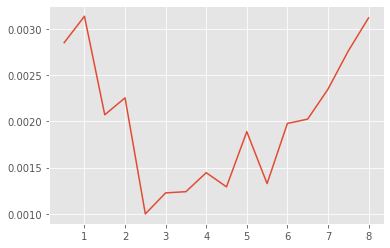

In [4]:
pd.Series(impliedrates, index=0.5 * np.array(range(1, 17))).plot()

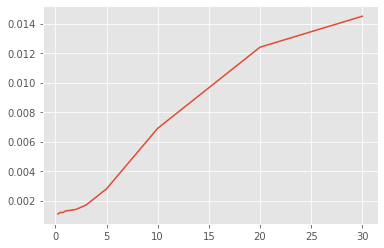

In [5]:
term_struct_trea.plot()

# Q5

In [6]:
corporate = pd.read_csv('Corporate_raw.csv').iloc[:,1:]
corporate.MATURITY = pd.to_datetime(corporate.MATURITY)
# Calculate accrual interest and full price
nextdate = pd.to_datetime(corporate.MATURITY.apply(lambda x : str(2020) + '-' + x.strftime('%m-%d')
                               if x.month > date.month else
                               str(2020) + '-' + (x+relativedelta(months=6)).strftime('%m-%d')))
accrual = nextdate.apply(lambda x: (x - date) / ((x+relativedelta(months=6)) - x))
corporate['PRICE'] = accrual*corporate.COUPON/2 + corporate.PRICE
corporate.MATURITY = corporate.MATURITY.apply(lambda x: x.strftime('%Y') + '06'
                                              if x.month < 6
                                              else x.strftime('%Y') + '12')

corporate.MATURITY = corporate.MATURITY.map(datemap)
corporate.dropna(inplace=True)
display(corporate)

,PRICE,COUPON,MATURITY
0,105.172624,2.650,5.0
4,128.295608,6.730,7.0
5,100.511119,2.125,1.0
6,104.803232,2.800,4.0
7,100.100846,0.625,11.0


In [7]:
# Filter out bonds with maturity after 2028 as we have no cashflow needs after that
# Hard code the newly added corporate bond
# 202211: 5
# 202311: 7
assets2 = assets.copy()
assets2 = assets2.append(corporate)
display(assets2)

def transform(x):
    cashflow = [0] * 16
    for i in range(x.MATURITY.astype('int')):
        if i != x.MATURITY.astype('int') - 1:
            cashflow[i] = x.COUPON / 2
        else:
            cashflow[i] = 100 + x.COUPON / 2
    return pd.Series(cashflow, index=list(range(1,17)))

n = 34 + 5 # number of assets
m = 16 # number of payment periods

# Construct bond payoff matrix (F matrix)
F = assets2.apply(lambda x: transform(x), axis=1)
display(F)
F = F.values.T

# Liabilities
L = np.array([11, 9, 7, 9, 9, 12, 6, 8, 
     10,  5, 7, 7, 8,  7, 9,  9,])

R = -np.identity(m)
R[1:m,0:m-1] = R[1:m,0:m-1]+np.identity(m-1)

r = np.identity(n)
for i in range(n - 2):
    r[i,i] = 0

p = np.array(assets2.PRICE)

,MATURITY,COUPON,PRICE
13,1.0,1.875,100.653657
14,1.0,1.750,100.705271
15,1.0,2.375,100.960367
16,1.0,2.500,101.012387
39,2.0,2.625,101.988519
40,2.0,1.125,100.600154
41,2.0,1.625,101.564000
42,2.0,2.125,101.845846
67,3.0,2.625,103.743519
68,3.0,1.625,101.806251


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
13,100.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
14,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
15,101.1875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
16,101.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
39,1.3125,101.3125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
40,0.5625,100.5625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
41,0.8125,100.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
42,1.0625,101.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
67,1.3125,1.3125,101.3125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
68,0.8125,0.8125,100.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [8]:
# cvxpy problem setup and solution
x = cp.Variable(n)
s = cp.Variable(m)
prob = cp.Problem(cp.Minimize(p.T@x),
                 [F@x + R@s == L, x>=0, p.T@r@x<=0.5*p.T@x, s>=0])
prob.solve() 

# Recall that cvxpy yields shadow prices with flipped sign
shadowprices = -prob.constraints[0].dual_value
impliedrates = 1/(shadowprices**(1/np.array(range(1,17))))-1

# Print result.
print("\nThe optimal value is", prob.value)
print("\nPortfolio x:")
# print(x.value)
# For better presentation
for i in x.value:
	print("{:.3f}".format(i))
print("\nSurplus s:")
print(s.value)
print("\nImplied rates:")
print(impliedrates)


The optimal value is 130.4696081814675

Portfolio x:
-0.000
0.000
0.000
0.000
0.082
0.000
0.000
0.000
0.000
0.061
0.000
0.000
-0.000
0.082
-0.000
-0.000
-0.000
-0.000
-0.001
-0.001
-0.001
0.055
-0.000
0.076
-0.000
0.000
0.096
0.047
-0.000
0.000
0.003
0.027
0.157
0.089
0.200
-0.000
0.100
-0.000
0.183

Surplus s:
[ 5.05915576e-07  9.18536409e-02 -1.74226987e-06 -3.68801631e-06
  1.17450404e+01  5.91196548e-04 -8.35981936e-07  1.20697513e-02
 -9.64715973e-06  1.33323866e-04  1.15517462e+01  5.08472507e+00
 -1.48626822e-05  8.87242592e+00 -3.07437215e-05  8.74101700e-05]

Implied rates:
[0.00552399 0.00313927 0.00207722 0.00227418 0.00281474 0.00125479
 0.00122527 0.00143632 0.00127804 0.00189503 0.00304475 0.00252738
 0.00200577 0.00233772 0.00218168 0.00310186]


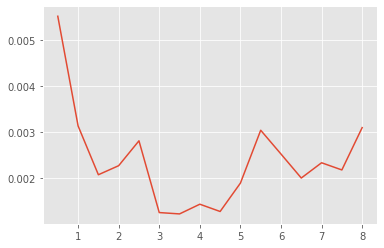

In [9]:
pd.Series(impliedrates, index=0.5 * np.array(range(1, 17))).plot()

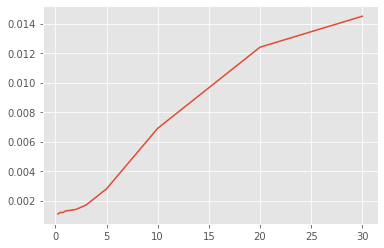

In [10]:
term_struct_trea.plot()